In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

%matplotlib notebook

In [3]:
%matplotlib notebook

In [6]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [8]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)
#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

#Condition using neural dynamics and command:
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]
df, A, M, n_da_mean, n_cond_list = bmi_b.df_predict_activity_conditioned_on_action(df, decoder, num_neurons, n_list)


('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)
F_hat close to F
K_hat close to K


In [9]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        


#------------------------------------------------------------
#Mappings: 

num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

<IPython.core.display.Javascript object>


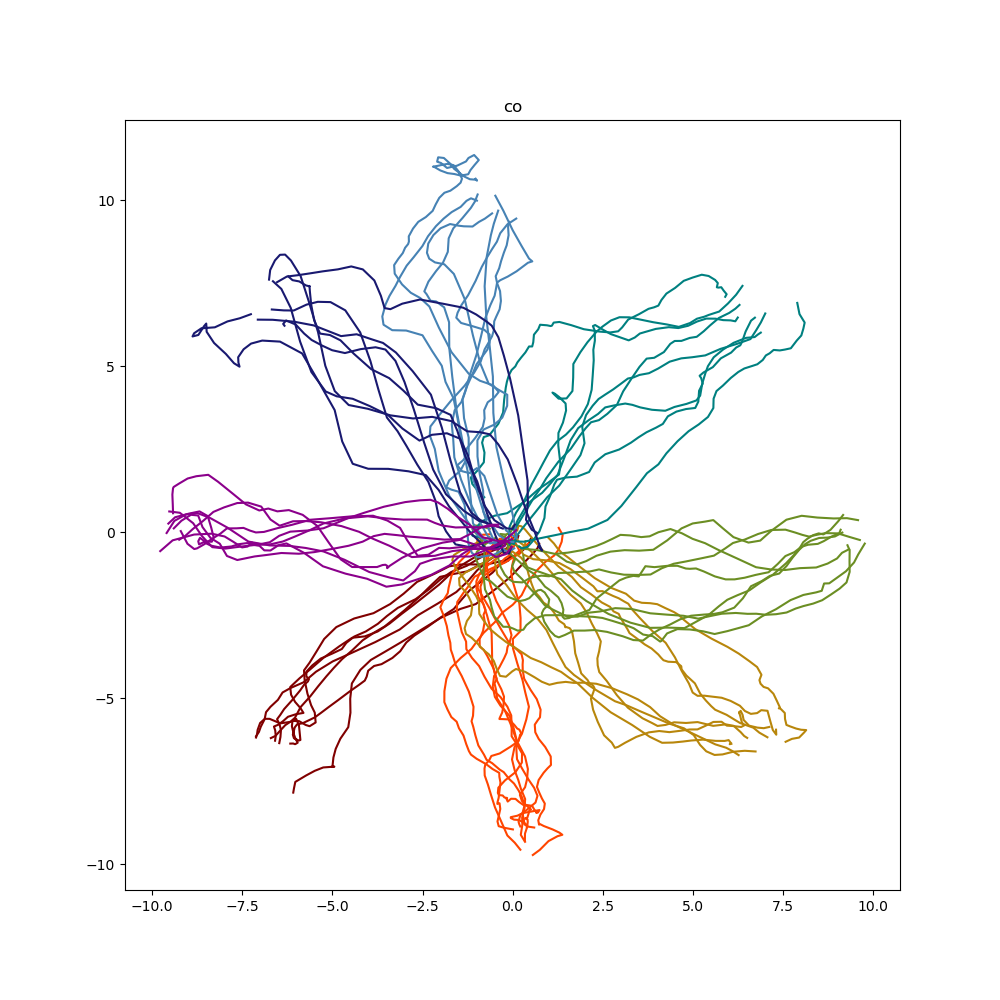

<IPython.core.display.Javascript object>


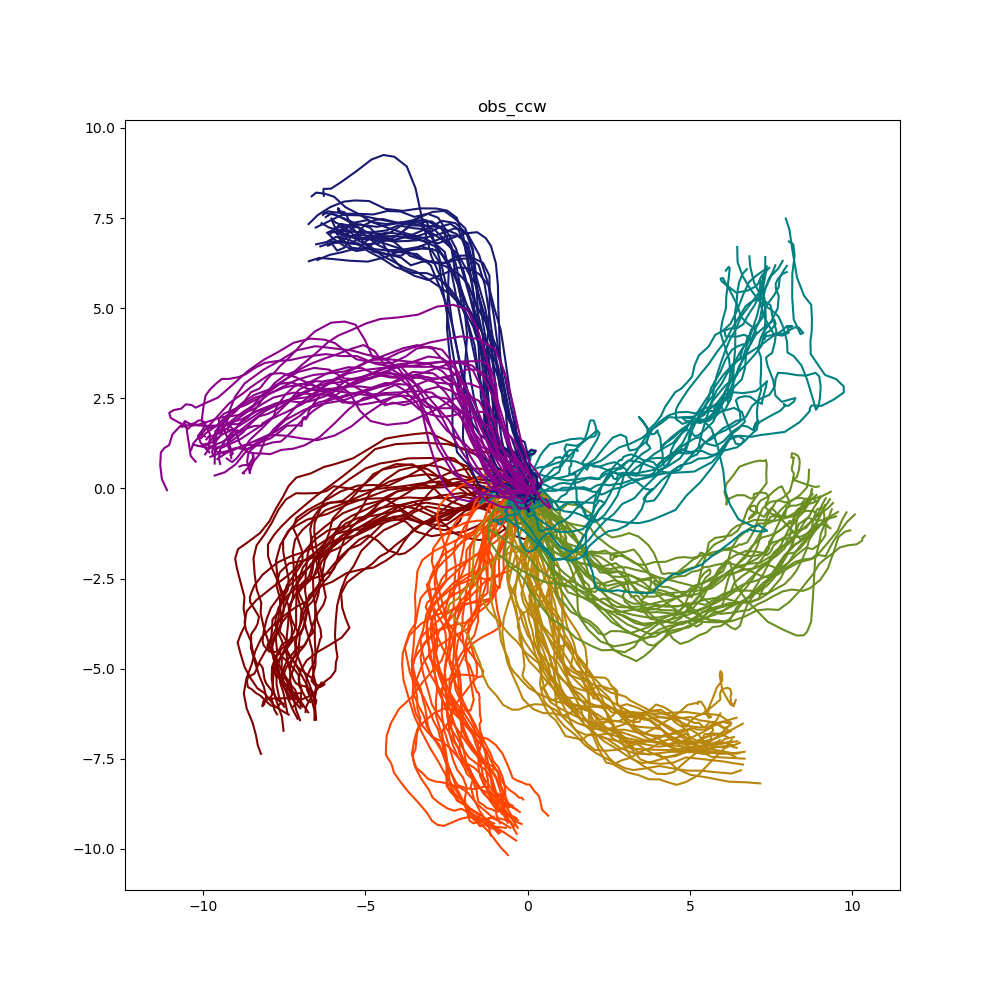

<IPython.core.display.Javascript object>


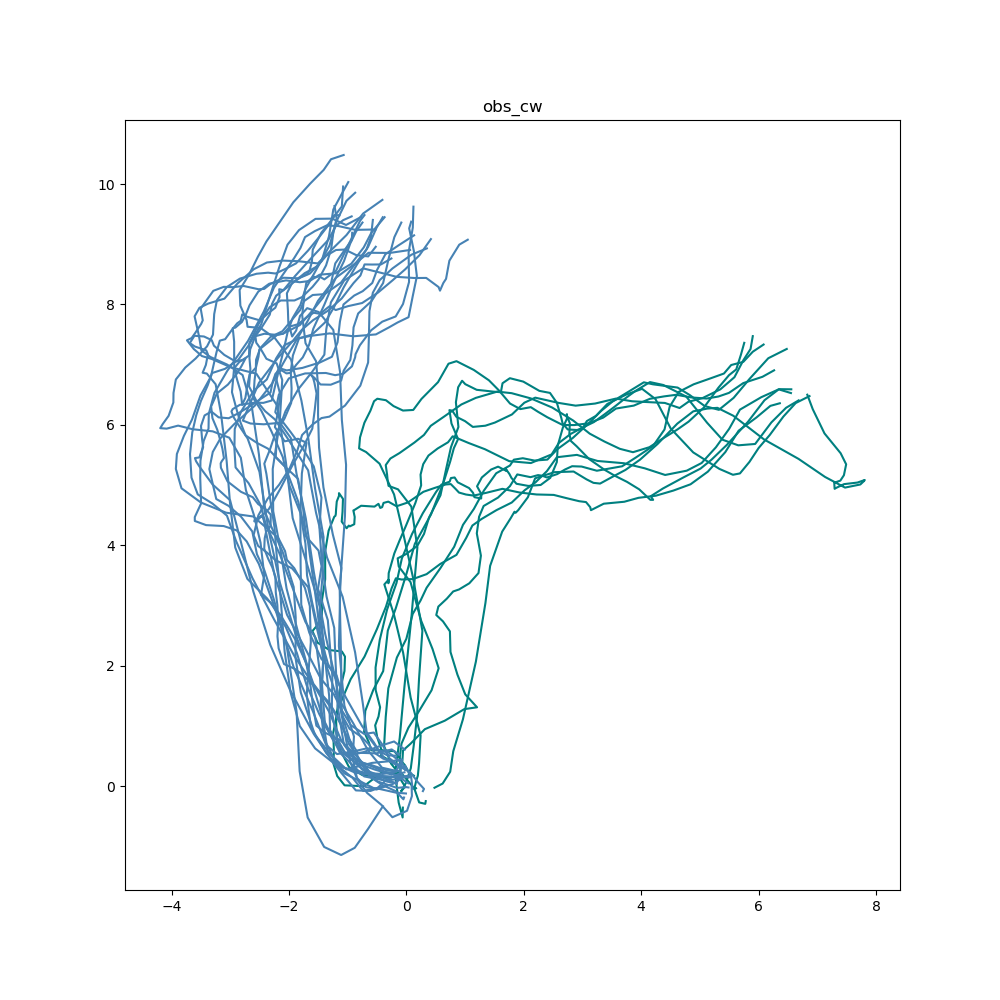

In [10]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

<IPython.core.display.Javascript object>


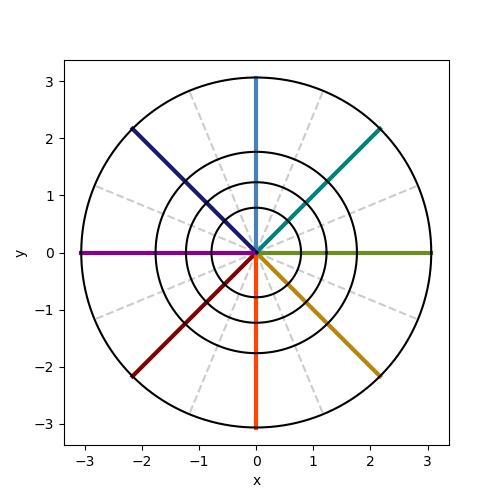

In [11]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### For each command, identify movements which have enough observations of each command.

In [12]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [13]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.

In [14]:
#Make a matrix of command X movement showing which command-movements have more than 15 observations
cm_mat = np.zeros((num_c, num_m))
for c in c_list:
    ci = c2idx[c]
    for m in cm_dic[c]:
        mi = m2idx[m]
        cm_mat[ci,mi]=1

#put it in an da: 
cm_da = xr.DataArray(cm_mat, \
    dims=['c', 'm'])

<IPython.core.display.Javascript object>


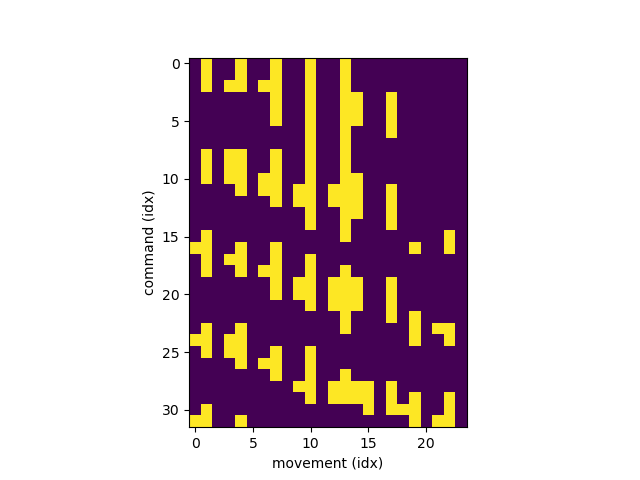

Text(0,0.5,'command (idx)')

In [15]:
plt.figure()
plt.imshow(cm_da)
plt.xlabel('movement (idx)')
plt.ylabel('command (idx)')

In [16]:
#Average number of movements a command appears in
cm_mat.sum(axis=1).mean()
#32 commmands, ~5 movements per command, ~10 movement pairs per command, ~320 (command, movement pairs)

5.40625

In [17]:
#Possible pairs:
cmpair_d = {}
for c in c_list: 
    cmpair_d[c, 'possible_pairs'] = [] #list of pairs
    for i,m1 in enumerate(cm_dic[c]):
        for j,m2 in enumerate(cm_dic[c]):
            pair = (m1,m2)
            if (j>i) and not (m1==m2) and not pair in cmpair_d[c, 'possible_pairs']:
                cmpair_d[c, 'possible_pairs'].append(pair)
        
        

In [18]:
### Match pairs
#For each c, have a pair of movements to compare
#loop command, m_pair, try to match them, if i can match them, then save in 'matched_pairs'
#save the observations to keep of each movement to ensure the pairs are matched.
t_start = timeit.default_timer()

match_var = ['u_vx', 'u_vy']
num_matched = 0
num_not_matched = 0

for c in c_list:
    cmpair_d[c,'matched_pairs'] = []
    cmpair_d[c,'not_matched_pairs'] = []
    
    for mp in cmpair_d[c,'possible_pairs']:
        m0=mp[0]
        m1=mp[1]

        #-------------------------------------------------------
        d_list = []
        d0=df.loc[cm_dic[c,m0,'sel'], match_var]
        d0_da = xr.DataArray(np.array(d0).T,
                    coords={'v':list(d0.columns),
                            'observation': d0.index.values},
                    dims=['v','observation'])

        d1=df.loc[cm_dic[c,m1,'sel'], match_var]
        d1_da = xr.DataArray(np.array(d1).T,
                    coords={'v':list(d1.columns),
                            'observation': d1.index.values},
                    dims=['v','observation'])

        d_list.append(d0_da)
        d_list.append(d1_da)

        #-------------------------------------------------------
        success, kept_list, discard_list, df_match, ttest_r, mean_r  = \
        bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=0.05, max_iter=20)
        
        cmpair_d[c,m0,m1,'match_success'] = success
        cmpair_d[c,m0,m1,'kept_list'] = kept_list
        cmpair_d[c,m0,m1,'discard_list'] = discard_list
        cmpair_d[c,m0,m1,'df_match'] = df_match
        cmpair_d[c,m0,m1,'ttest_r'] = ttest_r
        cmpair_d[c,m0,m1,'mean_r'] = mean_r
        
        if success:
            cmpair_d[c,'matched_pairs'].append(mp)
            num_matched += 1
        else:
            cmpair_d[c,'not_matched_pairs'].append(mp)
            num_not_matched += 1
            
t_elapsed = timeit.default_timer()-t_start
print('time elapsed: ', t_elapsed)

matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
reached max iter!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
matched!
m

In [20]:
#Calculate average neural activity, conditioned neural activity, and command trajectory:
#USE MATCHED DATA
t_start = timeit.default_timer()
for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
            
        #--------------------------------------------------------------------------------
        #n_mean: 
        n_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_list)
            n_mean_list.append(da.mean(dim='observation'))
        cmpair_d[c,mp[0],mp[1],'n_mean'] = n_mean_list
        cmpair_d[c,mp[0],mp[1],'n_diff'] = np.linalg.norm(n_mean_list[0]-n_mean_list[1])
        
        #--------------------------------------------------------------------------------
        #n_cond_mean: 
        n_cond_mean_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da = bmi_b.df_idx2da(df, idx, n_cond_list)
            n_cond_mean_list.append(da.mean(dim='observation'))
        cmpair_d[c,mp[0],mp[1],'n_cond_mean'] = n_cond_mean_list
        cmpair_d[c,mp[0],mp[1],'n_cond_diff'] = np.linalg.norm(n_cond_mean_list[0]-n_cond_mean_list[1])        


        #--------------------------------------------------------------------------------
        #u_psth:
        win = [-5,5]
        psth_var = ['u_vx', 'u_vy']
        psth_list = []
        psth_sem_list = []
        for idx in cmpair_d[c,mp[0],mp[1],'kept_list']:
            da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
            psth_list.append(psth)
            psth_sem_list.append(psth_sem)
        #ASSIGN:
        cmpair_d[c,mp[0],mp[1],'num_kept'] = np.array([obs0, obs1])
        cmpair_d[c,mp[0],mp[1],'u_psth'] = psth_list
        cmpair_d[c,mp[0],mp[1],'u_diff'] = np.linalg.norm(psth_list[0]-psth_list[1])
        cmpair_d[c,mp[0],mp[1],'u_psth_sem'] = psth_sem_list

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)


(0, 0)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 1)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 2)
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 3)
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (4, 1.2))
((2, 1.1), (5, 1.2))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((4, 1.1)

In [21]:
#-------------------------------------------------------------------------------------------------------------------
#USING ONLY MATCHED DATA:
t_start = timeit.default_timer()

# TODO: 
u_win = [-5,5] 
u_win_t = np.arange(u_win[0], u_win[1]+1)
# u_win_t = 0
df_list = []
df_columns = ['n_diff', 'n_cond_diff', 'u_diff',\
              'obs_0', 'obs_1',\
              'command_idx', 'movement_idx_0', 'movement_idx_1',\
              'u_v_mag_bin','u_v_angle_bin',\
              'target', 'task_rot']
#n_cond_diff : the difference between dynamics predicted+output conditioned neural activity

for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
            
        df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)


        df_i.loc[0,'n_diff'] = cmpair_d[c,mp[0],mp[1],'n_diff']
        df_i.loc[0,'n_cond_diff'] = cmpair_d[c,mp[0],mp[1],'n_cond_diff']
        
        u0 = cmpair_d[c,mp[0],mp[1],'u_psth'][0].loc[:,u_win_t]
        u1 = cmpair_d[c,mp[0],mp[1],'u_psth'][1].loc[:,u_win_t]

        df_i.loc[0,'u_diff'] = \
            np.linalg.norm(u0-u1)

        df_i.loc[0,'obs_0'] = obs0
        df_i.loc[0,'obs_1'] = obs1

        df_i.loc[0,'command_idx'] = c2idx[c]
        df_i.loc[0,'movement_idx_0'] = m2idx[mp[0]]
        df_i.loc[0,'movement_idx_1'] = m2idx[mp[1]]
        
        df_i.loc[0,'task_0'] = mp[0][1]
        df_i.loc[0,'task_1'] = mp[1][1]

        df_i.loc[0,'u_v_mag_bin'] = c[0]
        df_i.loc[0,'u_v_angle_bin'] = c[1]

        df_list.append(df_i)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
df_nu = pd.concat(df_list,ignore_index=True)

(0, 0)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 1)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 2)
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 3)
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (4, 1.2))
((2, 1.1), (5, 1.2))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((4, 1.1)

In [22]:
#-------------------------------------------------------------------------------------------------------------------
#Results df
t_start = timeit.default_timer()

# TODO: 
u_win = [-5,5] 
u_win_t = np.arange(u_win[0], u_win[1]+1)
# u_win_t = 0
df_list = []
df_columns = ['n_diff', 'n_cond_diff', 'u_diff',\
              'obs_0', 'obs_1',\
              'command_idx', 'movement_idx_0', 'movement_idx_1',\
              'u_v_mag_bin','u_v_angle_bin',\
              'target', 'task_rot']

for c in c_list:
    print(c)
    for mp in cmpair_d[c,'matched_pairs']:
        print(mp)
        obs0 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][0])
        obs1 = len(cmpair_d[c,mp[0],mp[1],'kept_list'][1])
            
        df_i = pd.DataFrame(np.zeros(len(df_columns)).reshape(1,-1), columns=df_columns)


        df_i.loc[0,'n_diff'] = cmpair_d[c,mp[0],mp[1],'n_diff']
        df_i.loc[0,'n_cond_diff'] = cmpair_d[c,mp[0],mp[1],'n_cond_diff']
        
        u0 = cmpair_d[c,mp[0],mp[1],'u_psth'][0].loc[:,u_win_t]
        u1 = cmpair_d[c,mp[0],mp[1],'u_psth'][1].loc[:,u_win_t]

        df_i.loc[0,'u_diff'] = \
            np.linalg.norm(u0-u1)

        df_i.loc[0,'obs_0'] = obs0
        df_i.loc[0,'obs_1'] = obs1

        df_i.loc[0,'command_idx'] = c2idx[c]
        df_i.loc[0,'movement_idx_0'] = m2idx[mp[0]]
        df_i.loc[0,'movement_idx_1'] = m2idx[mp[1]]
        
        df_i.loc[0,'task_0'] = mp[0][1]
        df_i.loc[0,'task_1'] = mp[1][1]

        df_i.loc[0,'u_v_mag_bin'] = c[0]
        df_i.loc[0,'u_v_angle_bin'] = c[1]

        df_list.append(df_i)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
df_nu = pd.concat(df_list,ignore_index=True)

(0, 0)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 1)
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 2)
((0, 1.1), (1, 0))
((0, 1.1), (1, 1.1))
((0, 1.1), (2, 0))
((0, 1.1), (2, 1.1))
((0, 1.1), (3, 1.1))
((0, 1.1), (4, 1.1))
((1, 0), (1, 1.1))
((1, 0), (2, 0))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1.1), (2, 0))
((1, 1.1), (2, 1.1))
((1, 1.1), (3, 1.1))
((1, 1.1), (4, 1.1))
((2, 0), (2, 1.1))
((2, 0), (3, 1.1))
((2, 0), (4, 1.1))
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((3, 1.1), (4, 1.1))
(0, 3)
((2, 1.1), (3, 1.1))
((2, 1.1), (4, 1.1))
((2, 1.1), (4, 1.2))
((2, 1.1), (5, 1.2))
((3, 1.1), (4, 1.2))
((3, 1.1), (5, 1.2))
((4, 1.1)

<IPython.core.display.Javascript object>


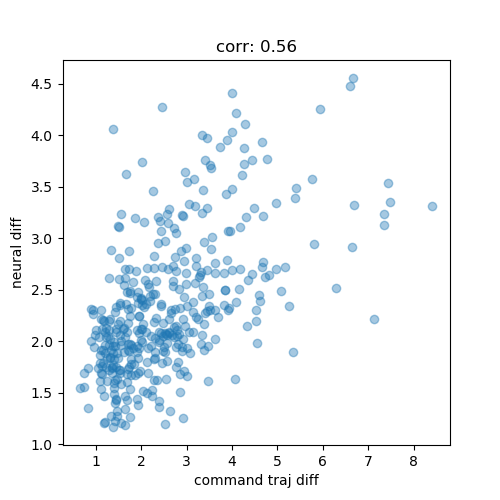

Text(0,0.5,'neural diff')

In [23]:
min_obs=15
sel = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)

u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff']
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.4)
plt.title('corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
# plt.xlim([0,7])

<IPython.core.display.Javascript object>


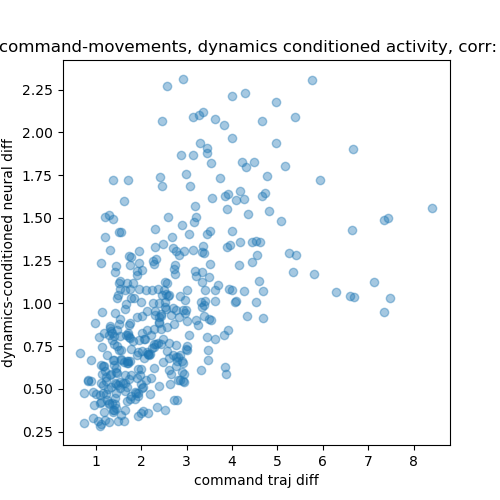

Text(0,0.5,'dynamics-conditioned neural diff')

In [29]:
#DYNAMICS + OUTPUT CONDITIONED: 

sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())       

sel = sel_obs 
#sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_str = 'all command-movements, dynamics conditioned activity'
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_cond_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n,alpha=0.4)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('dynamics-conditioned neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


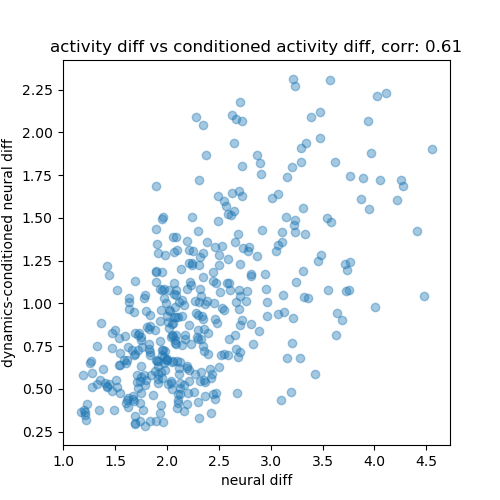

Text(0,0.5,'dynamics-conditioned neural diff')

In [33]:
#True Neural Diff vs Dynamics Conditioned Neural Diff: 

sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())       

sel = sel_obs 
#sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
sel_str = 'activity diff vs conditioned activity diff'
                        
n = df_nu.loc[sel,'n_diff']
ncond = df_nu.loc[sel,'n_cond_diff']
                        
corr_mat = np.corrcoef(n,ncond)
corr = corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(n,ncond,alpha=0.4)
plt.title(sel_str + ', corr: ' + str(round(corr,3)))
plt.xlabel('neural diff')
plt.ylabel('dynamics-conditioned neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


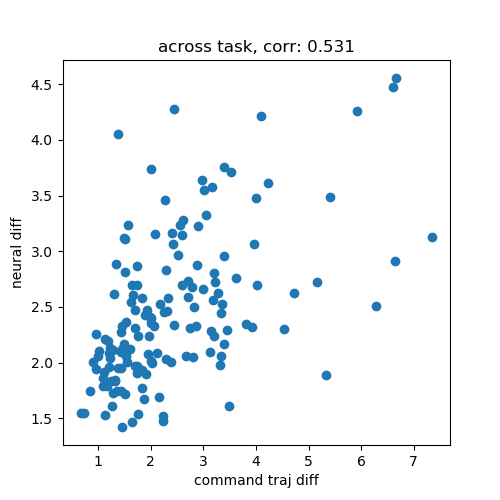

<IPython.core.display.Javascript object>


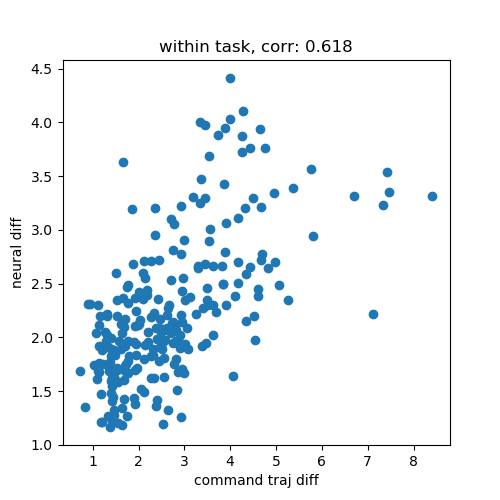

Text(0,0.5,'neural diff')

In [25]:
#Across Task vs Within Task


sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

#ACROSS TASK:
sel = sel_obs & sel_across_task
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title('across task, corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')


#WITHIN TASK:
sel = sel_obs & sel_within_task                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title('within task, corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')

### Pick an example command

<IPython.core.display.Javascript object>


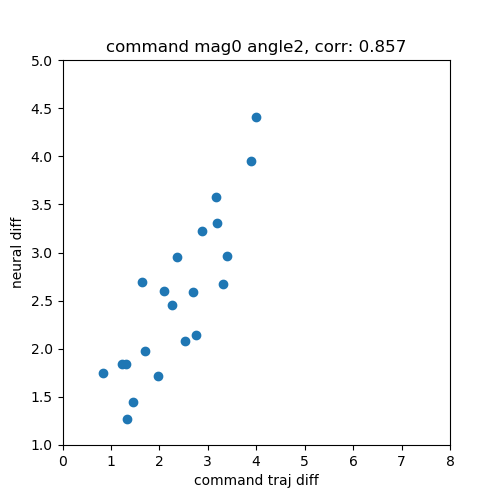

(1, 5)

In [34]:
# $[-5,5]
sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_obs & sel_command
sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('neural diff')
plt.xlim([0, 8])
plt.ylim([1, 5])

<IPython.core.display.Javascript object>


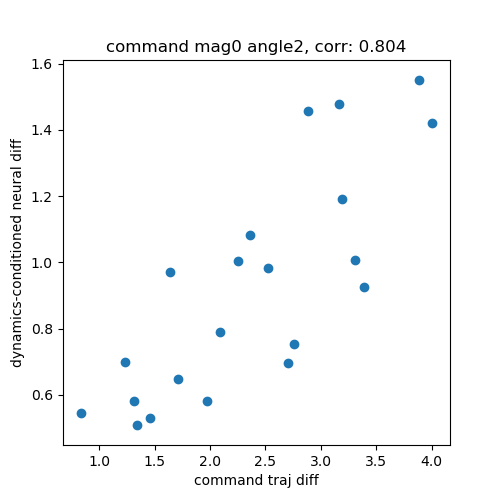

Text(0,0.5,'dynamics-conditioned neural diff')

In [37]:
# $[-5,5]
sel_obs = (df_nu.loc[:,'obs_0']>=min_obs) & (df_nu.loc[:,'obs_1']>=min_obs)
sel_across_task = (df_nu.loc[:,'task_0'].round()) != (df_nu.loc[:,'task_1'].round())
sel_within_task = (df_nu.loc[:,'task_0'].round()) == (df_nu.loc[:,'task_1'].round())

c_sel = (0,2)
sel_angle = (df_nu.loc[:,'u_v_angle_bin']==c_sel[1])
sel_mag = (df_nu.loc[:,'u_v_mag_bin']==c_sel[0])

sel_command = (sel_angle)&(sel_mag)
       

sel = sel_obs & sel_command
sel_str = 'command ' + 'mag' + str(c_sel[0]) + ' ' + 'angle' + str(c_sel[1])
                        
u = df_nu.loc[sel,'u_diff']
n = df_nu.loc[sel,'n_cond_diff']
                        
nu_corr_mat = np.corrcoef(u,n)
nu_corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.scatter(u,n)
plt.title(sel_str + ', corr: ' + str(round(nu_corr,3)))
plt.xlabel('command traj diff')
plt.ylabel('dynamics-conditioned neural diff')
# plt.xlim([0, 8])
# plt.ylim([1, 5])

<IPython.core.display.Javascript object>


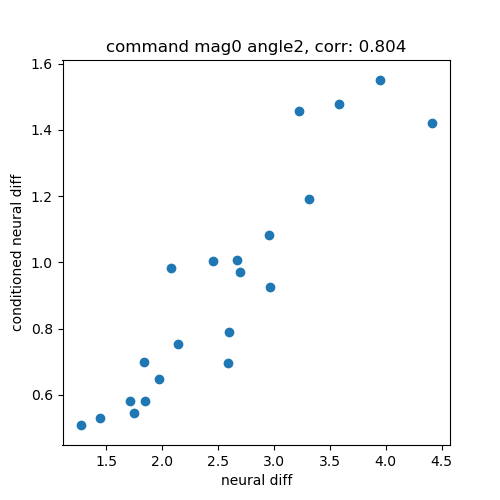

Text(0,0.5,'conditioned neural diff')

In [38]:
n = df_nu.loc[sel,'n_diff']
n_cond = df_nu.loc[sel,'n_cond_diff']

corr_mat = np.corrcoef(n,n_cond)
corr = nu_corr_mat[0,1]

plt.figure(figsize=(5,5))
plt.title(sel_str + ', corr: ' + str(round(corr,3)))
plt.scatter(n,n_cond)
plt.xlabel('neural diff')
plt.ylabel('conditioned neural diff')

### See the command-locked position trajectories

In [39]:
#get the movements in the command's matched_pairs
c = (0,2)
m_analyze = []
for mp in cmpair_d[c,'matched_pairs']:
    for m in mp: 
        if m not in m_analyze:
            m_analyze.append(m)
m_analyze

[(0, 1.1), (1, 0), (1, 1.1), (2, 0), (2, 1.1), (3, 1.1), (4, 1.1)]

In [40]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command
psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_list = []
psthc_list = []
for m in m_analyze: 
    idx = np.where(cm_dic[c,m,'sel'])[0]
    da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
    #center at lag0:
    psthc = psth-psth.loc[:,0]
    psth_list.append(psth)
    psthc_list.append(psthc) 

<IPython.core.display.Javascript object>


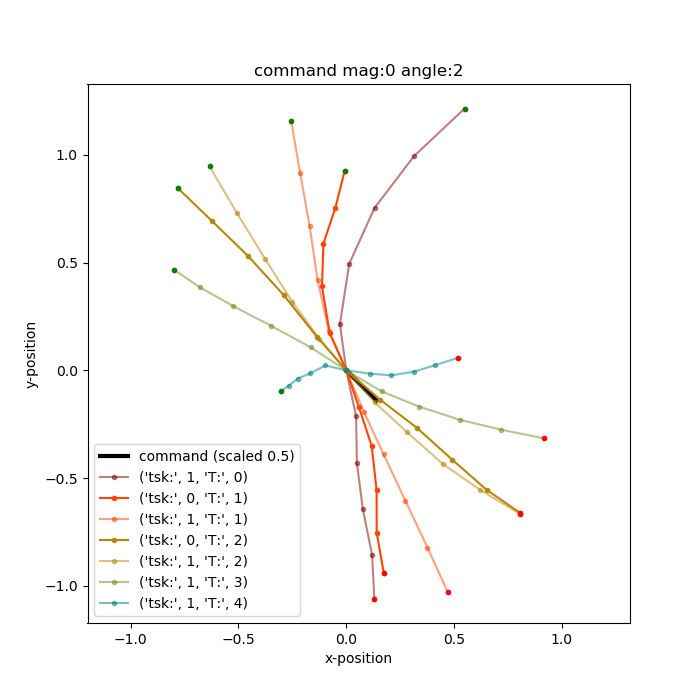

Text(0.5,1,'command mag:0 angle:2')

In [41]:
#PLOT the position PSTH

mag_bin = c[0]
angle_bin = c[1]
sc = 0.5

pm = mag_bin_c[mag_bin]
pa = angle_bin_c[angle_bin]
x_bin = pm*np.cos(pa)*sc
y_bin = pm*np.sin(pa)*sc

task_alpha = [1, 0.5]
plt.figure(figsize=(7,7))
plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
for i,psthc in enumerate(psthc_list):
    m = m_analyze[i]
    task = int(round(m[1]))
    target = int(m[0])
    plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
    plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
    plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  
    

plt.axis('equal')
plt.legend()
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

In [42]:
#Calculate u psth
psth_var = ['u_vx', 'u_vy']
win = [-5,5]
psth_list = []
psth_sem_list = []
for m in m_analyze: 
    idx = np.where(cm_dic[c,m,'sel'])[0]
    da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df, idx, win, psth_var)
    #center at lag0:
    psth_list.append(psth)
    psth_sem_list.append(psth_sem)

<IPython.core.display.Javascript object>


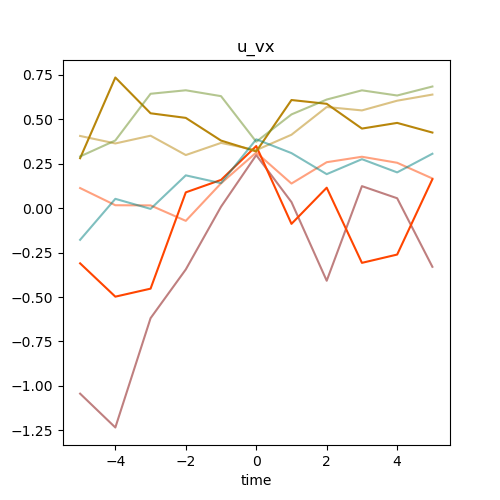

<IPython.core.display.Javascript object>


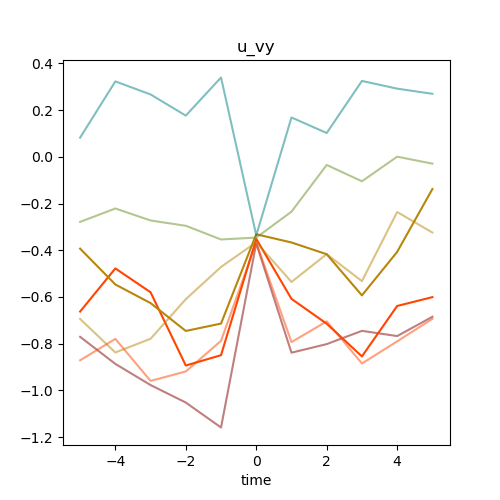

In [43]:
#Plot the u psth: 
mag_bin = c[0]
angle_bin = c[1]
sc = 0.5
t = np.arange(win[0],win[1]+1)
plot_sem = False

for v in psth_var:
    plt.figure(figsize=(5,5))
    plt.title(v)
    plt.xlabel('time')
    for i,m in enumerate(m_analyze):
        y = psth_list[i].loc[v,:]
        y_sem = psth_sem_list[i].loc[v,:]
        
        task = int(round(m[1]))
        target = int(m[0]) 
        
        plt.plot(t,y, color=target_color[target], alpha=task_alpha[task], label=('tsk:',task,'T:',target))
        if plot_sem:
            plt.fill_between(t,y-y_sem,y+y_sem,alpha=task_alpha[task]*0.5, color=target_color[target])
#     plt.legend()
    


# pm = mag_bin_c[mag_bin]
# pa = angle_bin_c[angle_bin]
# x_bin = pm*np.cos(pa)*sc
# y_bin = pm*np.sin(pa)*sc

# task_alpha = [1, 0.5]
# plt.figure(figsize=(7,7))
# plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
# for i,psthc in enumerate(psthc_list):
#     m = m_analyze[i]
#     task = int(round(m[1]))
#     target = int(m[0])
#     plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
#     plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
#     plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  
    

# plt.axis('equal')
# plt.legend()
# plt.xlabel('x-position')
# plt.ylabel('y-position')